In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("MainDataSet15m.csv")

In [26]:
df['Prev_Candle_Signal'] =df['Candle_Signal'].shift(1)
df['Prev_Candle'] = df['Candle'].shift(1)

In [27]:
df.columns

Index(['Day_Open', 'Day_High', 'Day_Low', 'Day_Close', 'Day_SuperTrend',
       'Day_Candle', 'Day_CandleBody', 'Day_5EMA', 'Day_15EMA', 'Day_20EMA',
       'Day_50EMA', 'Day_200EMA', 'Day_RSI', 'Day_upper_shadow_pr',
       'Day_lower_shadow_pr', 'Day_Candle_Signal', 'Day_Prev_Candle_Signal',
       'Day_Prev_Candle', 'Day_Date', 'Day_SwingMin', 'Day_SwingMax',
       'Datetime', 'Open', 'High', 'Low', 'Close', 'Pivot', 'Candle',
       'CandleBody', '5EMA', '15EMA', '20EMA', '50EMA', '200EMA', 'RSI',
       'SuperTrend', 'upper_shadow_pr', 'lower_shadow_pr', 'Candle_Signal',
       'Small_Swing_Min', 'Small_Swing_Max', 'Prev_Candle_Signal',
       'Prev_Candle'],
      dtype='object')

In [28]:
# status = (df['Pivot'] - df['Pivot'].shift(3) >= -50).shift(-6)
# df["TradSide"] = np.where(status, "PE", "None")
# df[df["TradSide"] != "None"]

In [29]:
# conditions = [
#     (df["Day_Prev_Candle_Signal"] == "Bearish") & (df["SuperTrend"] == -1) & (df["Prev_Candle_Signal"] == "Bearish") ,
#      (df["Day_Prev_Candle_Signal"] == "Bullish") & (df["SuperTrend"] == 1) & (df["Prev_Candle_Signal"] == "Bullish"),
# ]

# choices = ["PE", "CE"]

# df["TradSide"] = np.select(conditions, choices, default="None")


In [30]:
# ce_condition = ((df['High'].shift(1) < df['15EMA'].shift(1)) & (df["Close"] > df['15EMA'])) | ((df['Candle'].shift(2) == "Green") & (df['Candle'].shift(1) == "Red") & (df["Close"] >= df['High'].shift(1)) & (df['Low'].shift(2) <= df['Low'].shift(1)))
# pe_condition = ((df['Low'].shift(1) > df['15EMA'].shift(1)) & (df["Close"] < df['15EMA']) )| ((df['Candle'].shift(2) == "Red") & (df['Candle'].shift(1) == "Green") & (df["Close"] <= df['Low'].shift(1)) & (df['High'].shift(2) >= df['High'].shift(1)))
# df['TradSide'] = np.select([ce_condition, pe_condition], ['CE', 'PE'], default='None')

In [35]:
ce_condition = ((df['High'].shift(1) < df['15EMA'].shift(1)) & 
                (df["Close"] > df['15EMA']) & 
                ((df["Day_RSI"] <= 70) & (df["RSI"] <= 70)))

pe_condition = ((df['Low'].shift(1) > df['15EMA'].shift(1)) & 
                (df["Close"] < df['15EMA']) & 
                ((df["Day_RSI"] >= 20) & (df["RSI"] <= 20)))

df['TradSide'] = np.select([ce_condition, pe_condition], ['CE', 'PE'], default='None')

In [36]:
# df[df["TradSide"] == "PE"].tail()[[ "Datetime","TradSide",'Day_Candle_Signal', 'Day_Prev_Candle_Signal','Day_Prev_Candle','Day_Candle']]

In [37]:
import pandas as pd
from tabulate import tabulate
class Trader:
    def __init__(self,initial_balance=100000):
        self.balance = initial_balance
        self.RiskToReward  = "1:2"
        self.trad_book = pd.DataFrame(columns=['IndexName', 'TradSide', 'Status', 'Quantity', 'BuyPrice',
                                               'BuyDatetime', 'SellPrice', 'SellDatetime','SLValue',
                                               'TargetValue', 'PnL Status','PnL'])
        

    def backtest(self, df):
        open_order = None
        TradSide = None
        tg_order = None
        sl_order = None

        for index, row in df.iterrows():
            if row["TradSide"] != "None" and open_order is None:
                open_order = row["Open"]
                TradSide = row["TradSide"]
                sl = 20 * int(self.RiskToReward.split(":")[0])
                tg = sl * int(self.RiskToReward.split(":")[1])
                sl_order, tg_order = (open_order - sl, open_order + tg) if TradSide == "CE" else (open_order + sl, open_order - tg)
                symbol = "Nifty50"
                quantity = 10
                new_log = pd.DataFrame({'IndexName': [symbol],'TradSide':[TradSide],'Status':["Open"] ,'Quantity': [quantity], 'BuyPrice': [open_order],
                                'BuyDatetime': [row["Datetime"]], 'SellDatetime': [None], 'SellPrice': [None],
                                'PnL': [0],'SLValue': [sl_order], 'TargetValue': [tg_order], 'PnL Status': [None] })
                self.trad_book = pd.concat([self.trad_book, new_log], ignore_index=True)
            if open_order is not None:
                if (TradSide == "CE" and (row["Close"] >= tg_order or row["Close"] <= sl_order)) or \
                   (TradSide == "PE" and (row["Close"] <= tg_order or row["Close"] >= sl_order)):
                    pnl = row["Close"] - open_order if TradSide == "CE" else open_order - row["Close"]
                    self.balance += pnl
                    
                    index = self.trad_book.shape[0] -1
                    self.trad_book.at[index, 'SellPrice'] = row["Close"]
                    self.trad_book.at[index, 'SellDatetime'] = row["Datetime"]
                    self.trad_book.at[index, 'Status'] = "Done"
                    self.trad_book.at[index, 'PnL'] = pnl
                    self.trad_book.at[index, 'PnL Status'] = "Profit" if  pnl >0  else "Loss"
                    self.trad_book.at[index, 'SellDatetime'] = row["Datetime"]
                    open_order = None

    
    def stats(self):
            df = self.trad_book
            total_trade = len(df.index)
            pnl = df.PnL.sum()
            winners = len(df[df.PnL > 0])
            losers = len(df[df.PnL <= 0])
            win_ratio = round((winners / total_trade) * 100, 2)
    
            # Calculate CE and PE trades
        
            ce_trades = f"{(len(df[(df['TradSide'] == 'CE') & (df['PnL'] > 0)]) / len(df[df['TradSide'] == 'CE']) * 100):.2f}%" if len(df[df['TradSide'] == 'CE']) != 0 else 0
            pe_trades = f"{(len(df[(df['TradSide'] == 'PE') & (df['PnL'] > 0)]) / len(df[df['TradSide'] == 'PE']) * 100):.2f}%" if len(df[df['TradSide'] == 'PE']) != 0 else 0

    
            # Calculate additional metrics
            capital = self.balance
            max_win = round(df[df.PnL > 0].PnL.max(), 2) if winners > 0 else 0
            max_profit_sum = round(df[df.PnL > 0].PnL.sum(), 2) if winners > 0 else 0
            max_loss = round(df[df.PnL <= 0].PnL.min(), 2) if losers > 0 else 0
            max_loss_sum = round(df[df.PnL <= 0].PnL.sum(), 2) if losers > 0 else 0
            total_profit = round(df.PnL.sum(), 2)
            total_profit_percentage = round((total_profit / self.balance) * 100, 2)
            trading_days = pd.to_datetime(df['BuyDatetime']).dt.strftime('%Y%m%d').nunique()

    
            # Prepare the data for tabular representation
            # parameters = ['Total Trades', 'Capital', 'Total Wins', 'Total Losses', 'Win Ratio',
            #               'Max Win', 'Max Win Score','Max Loss', 'Max Loss Score','Total Profit', ' Grow Profit %',
            #               'CE Trades', 'PE Trades', 'Stategy Name']


            parameters = ['Total Trading Days','Total Trades','RiskToReward','Capital', 'Total Wins', 'Total Losses', 'Win Ratio','Total Profit', 'Grow Profit %',
                              'Max Win', 'Max Win Score','Max Loss', 'Max Loss Score','CE Trades', 'PE Trades', 'Stategy Name']


        
            data_points = [trading_days,total_trade, self.RiskToReward ,capital, winners, losers, f"{win_ratio}%",total_profit,f"{total_profit_percentage}%",
                           max_win, max_profit_sum,max_loss, max_loss_sum,ce_trades, pe_trades, "Test"]

        
            data = list(zip(parameters, data_points))
    
            # Print the tabular representation
            print(tabulate(data, headers=['Parameters', 'Values'], tablefmt='psql'))
    
            excel_file = "statistics.csv"
            try:
                existing_df = pd.read_csv(excel_file)
                new_data = pd.DataFrame([data_points], columns=parameters)
                updated_df = pd.concat([existing_df, new_data], ignore_index=True)
                updated_df.to_csv(excel_file, index=False)
            except FileNotFoundError:
                new_data = pd.DataFrame([data_points], columns=parameters)
                new_data.to_csv(excel_file, index=False)

trader = Trader()
trader.backtest(df)
trader.stats()


+--------------------+--------------------+
| Parameters         | Values             |
|--------------------+--------------------|
| Total Trading Days | 191                |
| Total Trades       | 224                |
| RiskToReward       | 1:2                |
| Capital            | 106202.70000000004 |
| Total Wins         | 148                |
| Total Losses       | 76                 |
| Win Ratio          | 66.07%             |
| Total Profit       | 6202.7             |
| Grow Profit %      | 5.84%              |
| Max Win            | 228.6              |
| Max Win Score      | 9200.05            |
| Max Loss           | -296.7             |
| Max Loss Score     | -2997.35           |
| CE Trades          | 64.29%             |
| PE Trades          | 73.81%             |
| Stategy Name       | Test               |
+--------------------+--------------------+


In [9]:
tk = trader.trad_book

In [10]:
ViewList =["Datetime","Day_Prev_Candle_Signal","Day_Prev_Candle","Day_RSI","RSI","Prev_Candle_Signal","Prev_Candle","TradSide"]
row_data = df[df["Datetime"].isin(tk["BuyDatetime"])].reset_index(drop=True)[ViewList]

In [11]:
df_ce =row_data[row_data["TradSide"] =="CE"]
df_ce

,Datetime,Day_Prev_Candle_Signal,Day_Prev_Candle,Day_RSI,RSI,Prev_Candle_Signal,Prev_Candle,TradSide
0,2021-11-18 13:15:00,Bearish,Red,24.515472,76.525050,Bullish,Green,CE
1,2021-11-22 15:15:00,Neutral,Red,11.914958,68.037540,Bearish,Green,CE
2,2021-11-23 11:15:00,Bullish,Red,24.754704,71.027153,Bearish,Green,CE
3,2021-11-25 11:00:00,Neutral,Red,39.078949,73.911789,Bullish,Green,CE
6,2021-11-29 10:00:00,Bullish,Red,20.217705,65.605162,Bearish,Green,CE
...,...,...,...,...,...,...,...,...
719,2024-05-06 10:15:00,Bullish,Red,40.360887,56.072640,Bullish,Green,CE
722,2024-05-07 13:30:00,Neutral,Red,27.384665,71.484709,Bullish,Green,CE
723,2024-05-08 11:15:00,Bullish,Red,27.384665,63.846946,Neutral,Green,CE
724,2024-05-10 09:15:00,Bearish,Red,27.400830,65.142190,Bullish,Green,CE


In [12]:
print(f"RSI : {df_ce['RSI'].mean()}")
print(f"DAY RSI : {df_ce['Day_RSI'].mean()}")

RSI : 67.85656484641974
DAY RSI : 49.592625193765926


<Axes: >

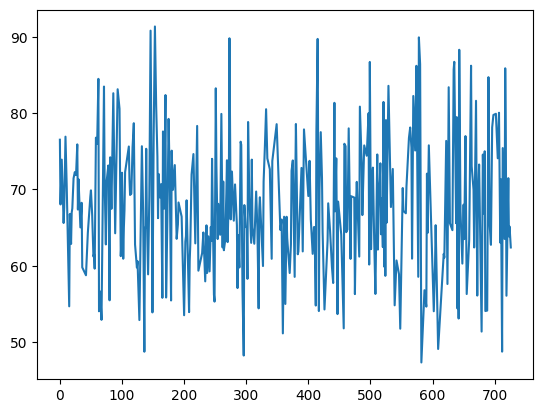

In [13]:
df_ce["RSI"].plot()

<Axes: >

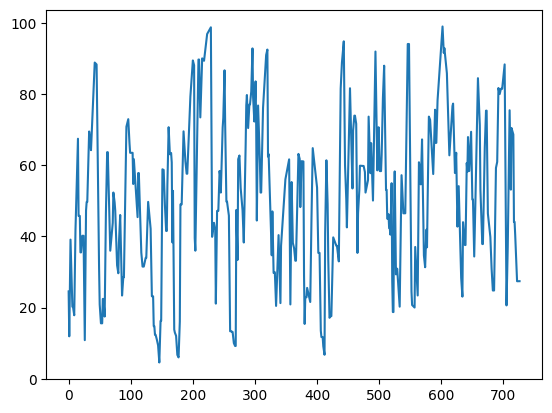

In [14]:
df_ce["Day_RSI"].plot()

In [15]:
df_pe =row_data[row_data["TradSide"] =="PE"]
df_pe

,Datetime,Day_Prev_Candle_Signal,Day_Prev_Candle,Day_RSI,RSI,Prev_Candle_Signal,Prev_Candle,TradSide
4,2021-11-25 12:45:00,Neutral,Red,39.078949,38.853265,Neutral,Red,PE
5,2021-11-26 09:15:00,Bullish,Green,16.971518,11.122614,Bearish,Green,PE
8,2021-11-29 12:45:00,Bullish,Red,20.217705,32.200192,Neutral,Red,PE
10,2021-11-30 11:00:00,Bullish,Red,17.828338,27.632572,Bullish,Red,PE
12,2021-12-03 12:00:00,Neutral,Green,44.031197,37.857578,Bullish,Red,PE
...,...,...,...,...,...,...,...,...
714,2024-04-30 13:00:00,Bullish,Green,64.919377,19.329278,Bearish,Red,PE
715,2024-04-30 14:45:00,Bullish,Green,64.919377,21.665814,Bearish,Red,PE
720,2024-05-06 11:15:00,Bullish,Red,40.360887,44.854452,Bearish,Red,PE
721,2024-05-06 12:15:00,Bullish,Red,40.360887,39.782419,Bullish,Green,PE


In [16]:
print(f"RSI : {df_pe['RSI'].mean()}")
print(f"DAY RSI : {df_pe['Day_RSI'].mean()}")

RSI : 30.821605223469128
DAY RSI : 55.881594332657116


<Axes: >

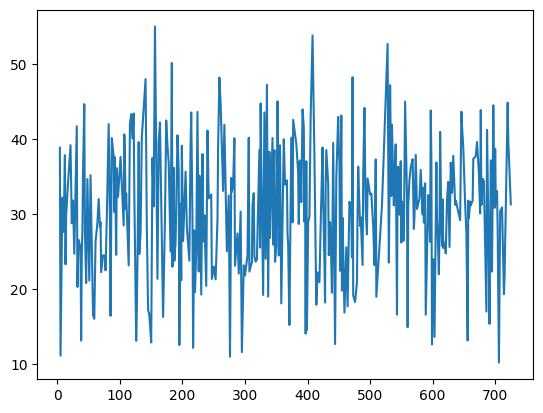

In [17]:
df_pe["RSI"].plot()

<Axes: >

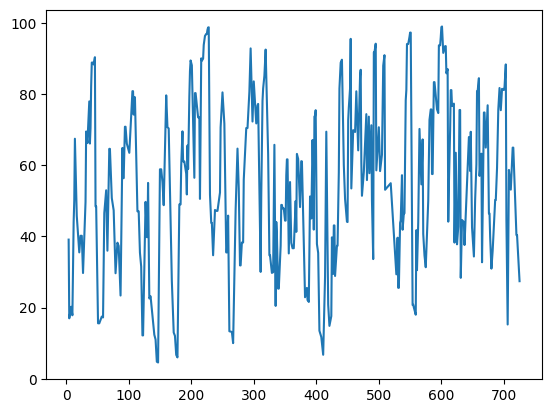

In [18]:
df_pe["Day_RSI"].plot()

<Axes: >

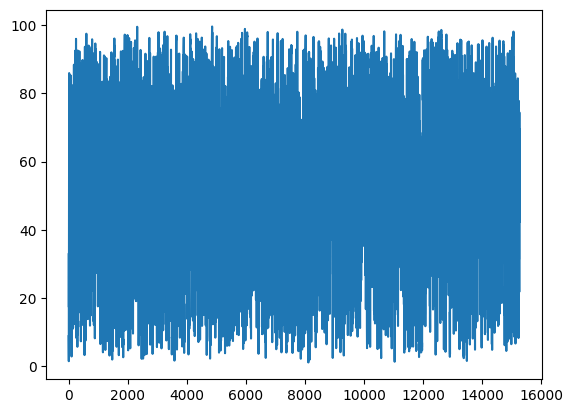

In [19]:
df["RSI"].plot()

<Axes: >

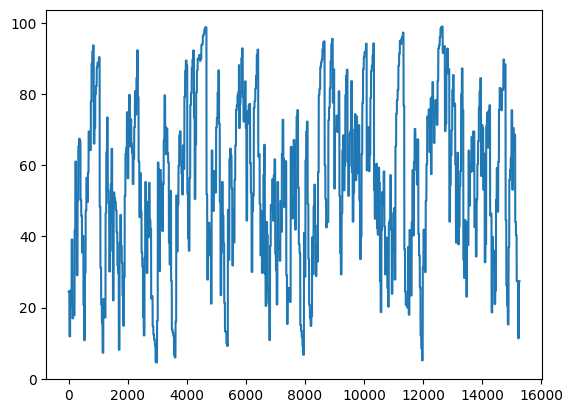

In [20]:
df["Day_RSI"].plot()